# PASSO 0 - SETUP

## <i><font color="#708090" size=5>0.0 IMPORTS</font></i>

In [71]:
import pandas              as pd
import numpy               as np
import seaborn             as sns
import inflection
import math
import matplotlib.pyplot   as plt

from IPython.core.display  import HTML
from IPython.display       import Image
from tabulate              import tabulate
from scipy                 import stats     as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestRegressor

## <i><font color="#708090" size=5>0.1 HELPER FUNCTIONS</font></i>

<b>Nota 1:</b>
Cramér's V: é uma medida de associação (correlação) entre duas variáveis categóricas,
cuja análise é baseada apenas nos nomes das variáveis. 
Explicação detalhada do cálculo em: 
<a>https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V</a>

In [2]:
def cramer_v(x, y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 )))

<b>Nota 2:</b>
jupyter_settings configura a exibição dos gráficos plotados na tela pela classe seaborn 

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

## <i><font color="#708090" size=5>0.2 LOADING DATA</font></i>

In [4]:
df_sales_raw = pd.read_csv( '~/repos/DataScience_Em_Producao/data/train.csv', low_memory=False )
df_store_raw = pd.read_csv( '~/repos/DataScience_Em_Producao/data/store.csv', low_memory=False )

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# settings plot
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# 1º PASSO - Descrição dos Dados

In [5]:
# secutiry copy of dataset
df1 = df_raw.copy()

## <i><font color="#708090" size=5>1.1 Rename Columns</font></i>

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

## <i><font color="#708090" size=5>1.2 Data Dimensions</font></i>

In [7]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## <i><font color="#708090" size=5>1.3 Data Types</font></i>

In [8]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## <i><font color="#708090" size=5>1.4 Check NA</font></i>

In [9]:
# sum of NA rows
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## <i><font color="#708090" size=5>1.5 Fillout NA</font></i>

In [10]:
#competition_distance            NA=2642
df1['competition_distance'] = df1['competition_distance'].apply( 
    lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month    NA=323348
df1['competition_open_since_month'] = df1.apply( 
    lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) 
    else x['competition_open_since_month'], axis=1 )

#competition_open_since_year     NA=323348
df1['competition_open_since_year'] = df1.apply(
    lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) 
    else x['competition_open_since_year'], axis=1 )

#promo2_since_week               NA=508031
df1['promo2_since_week'] = df1.apply( 
    lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) 
    else x['promo2_since_week'], axis=1 )

#promo2_since_year               NA=508031
df1['promo2_since_year'] = df1.apply( 
    lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) 
    else x['promo2_since_year'], axis=1 )

#promo_interval                  NA=508031
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
            7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( 
    lambda x: 0 if x['promo_interval'] == 0 
    else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1 )


In [11]:
df1.sample(5).T

,908598,67191,957528,730755,547514
store,659,292,529,101,835
day_of_week,1,1,6,6,3
date,2013-04-08 00:00:00,2015-06-01 00:00:00,2013-02-23 00:00:00,2013-09-14 00:00:00,2014-02-26 00:00:00
sales,7892,8563,5853,5899,3776
customers,912,930,635,766,543
open,1,1,1,1,1
promo,1,1,0,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,d,a,d,d,a


In [12]:
# checkout all NA
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## <i><font color="#708090" size=5>1.6 Change Types</font></i>

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int) 

## <i><font color="#708090" size=5>1.7 Descriptive Statistical</font></i>

In [14]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]']) 

### 1.7.1 Numerical Attributes

In [15]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame( num_attributes.apply( np.median )).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std )).T
d2 = pd.DataFrame( num_attributes.apply( np.min )).T
d3 = pd.DataFrame( num_attributes.apply( np.max )).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

# concatenate
metrics = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
metrics.columns = ['attributes', 'min', 'max', 'range', 'mean', 
                   'median', 'std', 'skew', 'kurtosis']
metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


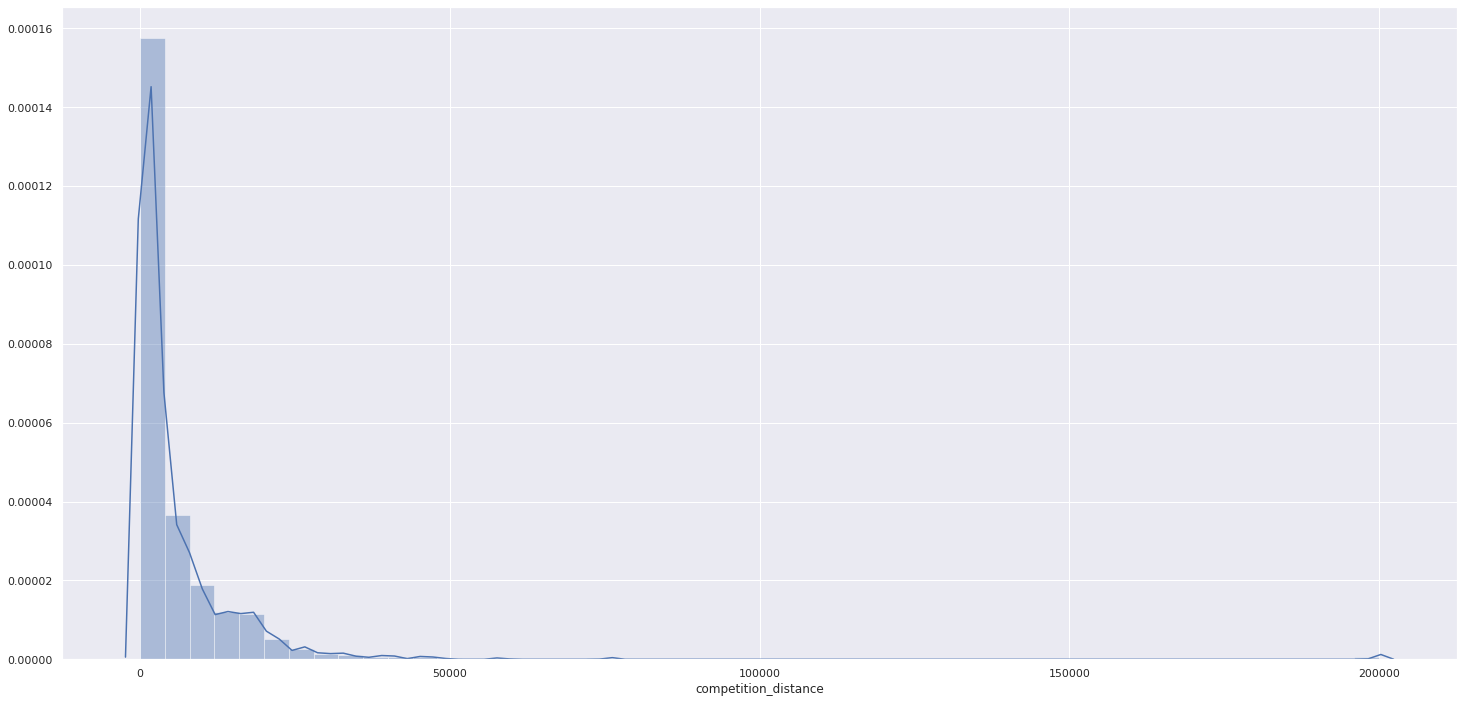

In [16]:
sns.distplot( df1['competition_distance'] ) 

### 1.7.2 Categorical Attributes

In [17]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

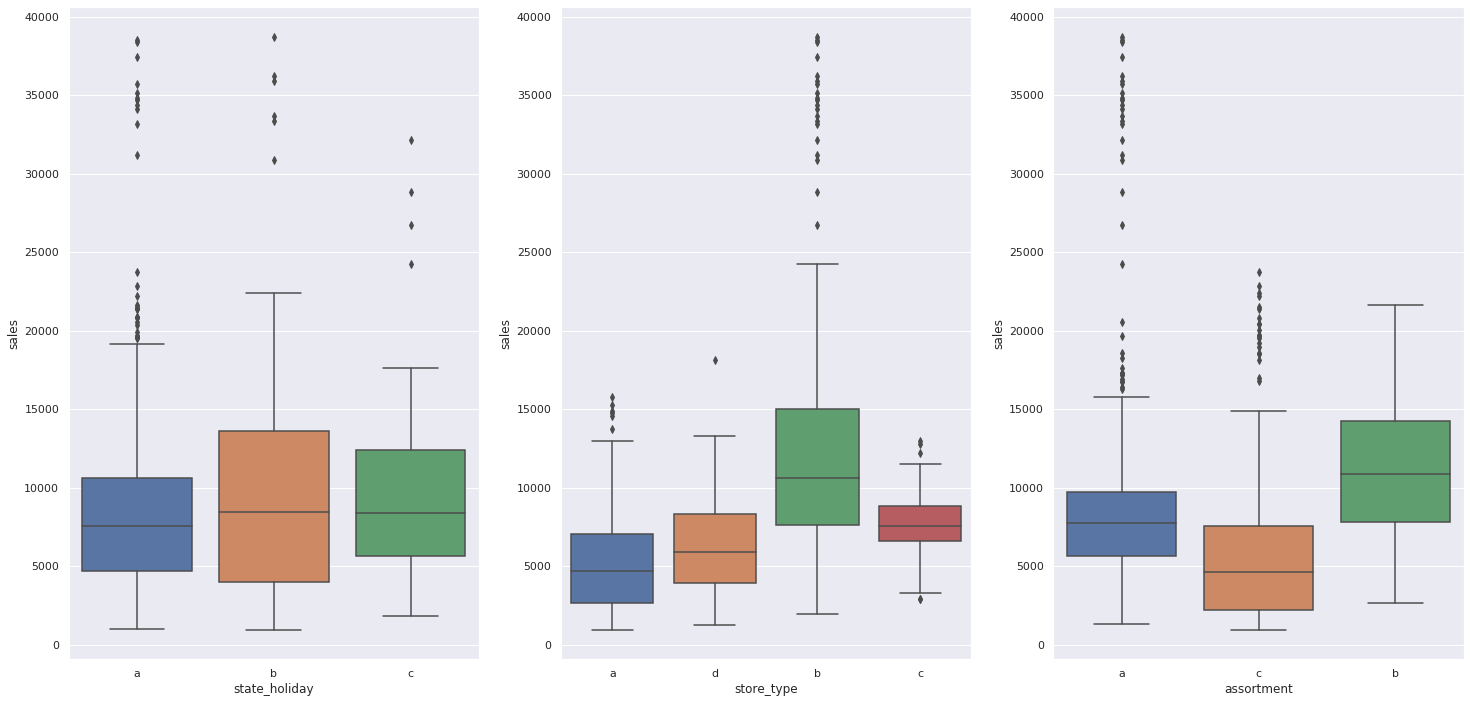

In [18]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux1 )

plt.subplot(1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux1 )

plt.subplot(1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux1 )

# 2º PASSO - Feature Engineering

In [19]:
# secutiry copy of dataset
df2 = df1.copy()

## <i><font color="#708090" size=5>2.1 Mapa Mental de Hipóteses</font></i>

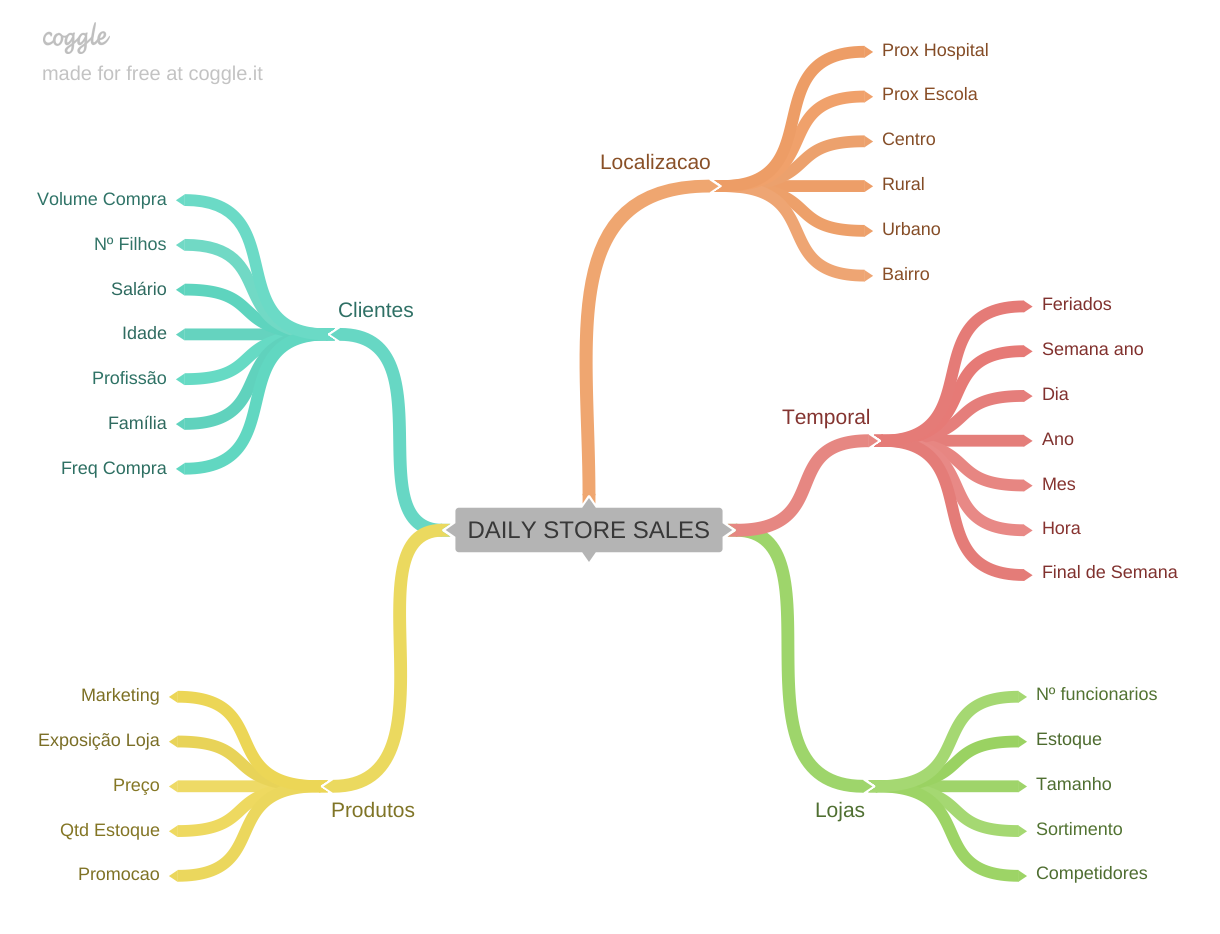

In [20]:
Image('img/MindMapHypothesis.png')

## <i><font color="#708090" size=5>2.2 Criação das Hipóteses</font></i>

### <i><font color="a9a9a9" size=4>2.2.1 Hipóteses de Lojas</font></i>

**1.** Lojas com maior nº de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior tamanho deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores há mais tempo deveriam vender mais.

### <i><font color="a9a9a9" size=4>2.2.2 Hipóteses de Produto</font></i>

**1.** Lojas com maior investimento em Marketing deveriam vender mais.

**2.** Lojas com Produtos com maior esposição nas vitrines deveriam vender mais.

**3.** Lojas com Produtos com menores preços deveriam vender mais.

**4.** Lojas com promoções mais agressivas deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoções deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### <i><font color="a9a9a9" size=4>2.2.3 Hipóteses de Tempo</font></i>

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mes.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## <i><font color="#708090" size=5>2.3 Lista Final de Hipóteses</font></i>

**Hipóteses validáveis diretamente a partir do dataset**


**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores há mais tempo deveriam vender mais.


**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoções deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.


**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mes.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## <i><font color="#708090" size=5>2.4 Feature Engineering</font></i>

In [21]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( 
                                                year=x['competition_open_since_year'],
                                                month=x['competition_open_since_month'],
                                                day=1 ), axis=1 )
df2['competition_time_month'] = (( df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str)+'-'+df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply( lambda x: 
                    datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = (( df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 
                                             'basic' if x=='a' else
                                             'extra' if x=='b' else
                                             'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 
                                             'public_holiday' if x=='a' else
                                             'easter_holiday' if x=='b' else
                                             'christmas'      if x=='c' else
                                             'regular_day')


In [22]:
df2.sample(5).T

,411216,291635,92085,430825,113143
store,567,107,656,106,529
day_of_week,6,7,7,2,2
date,2014-06-28 00:00:00,2014-11-02 00:00:00,2015-05-10 00:00:00,2014-06-10 00:00:00,2015-04-21 00:00:00
sales,3502,0,0,9453,6350
customers,488,0,0,925,633
open,1,0,0,1,1
promo,0,0,0,0,0
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,0,0,0,0,0
store_type,c,a,d,a,d


# 3º PASSO - Filtragem de Variáveis

In [23]:
# secutiry copy of dataset
df3 = df2.copy()

## <i><font color="#708090" size=5>3.1 Filtragem das Linhas</font></i>

In [24]:
# não interessa ao modelo open == 0, ou seja, quando as lojas estão fechadas
# não interessa ao modelo sales == 0, ou seja, quando as lojas estão fechadas

df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## <i><font color="#708090" size=5>3.2 Seleção das Colunas</font></i>

In [25]:
# 'customers' - não há como prever a quantidade de clientes nas pŕoximas 6 semanas
# 'open' - após a filtragem das linhas, esta coluna só possui valores iguais a 1
# 'promo_interval', 'month_map' - colunas auxiliares irrelevantes para esta etapa

cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [26]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4º PASSO - EDA (Análise Exploratória dos Dados)

In [27]:
# secutiry copy of dataset
df4 = df3.copy()

## <i><font color="#708090" size=5>4.1. Análise Univariada</font></i>

### <i><font color="a9a9a9" size=4>4.1.1 Response Variable</font></i>

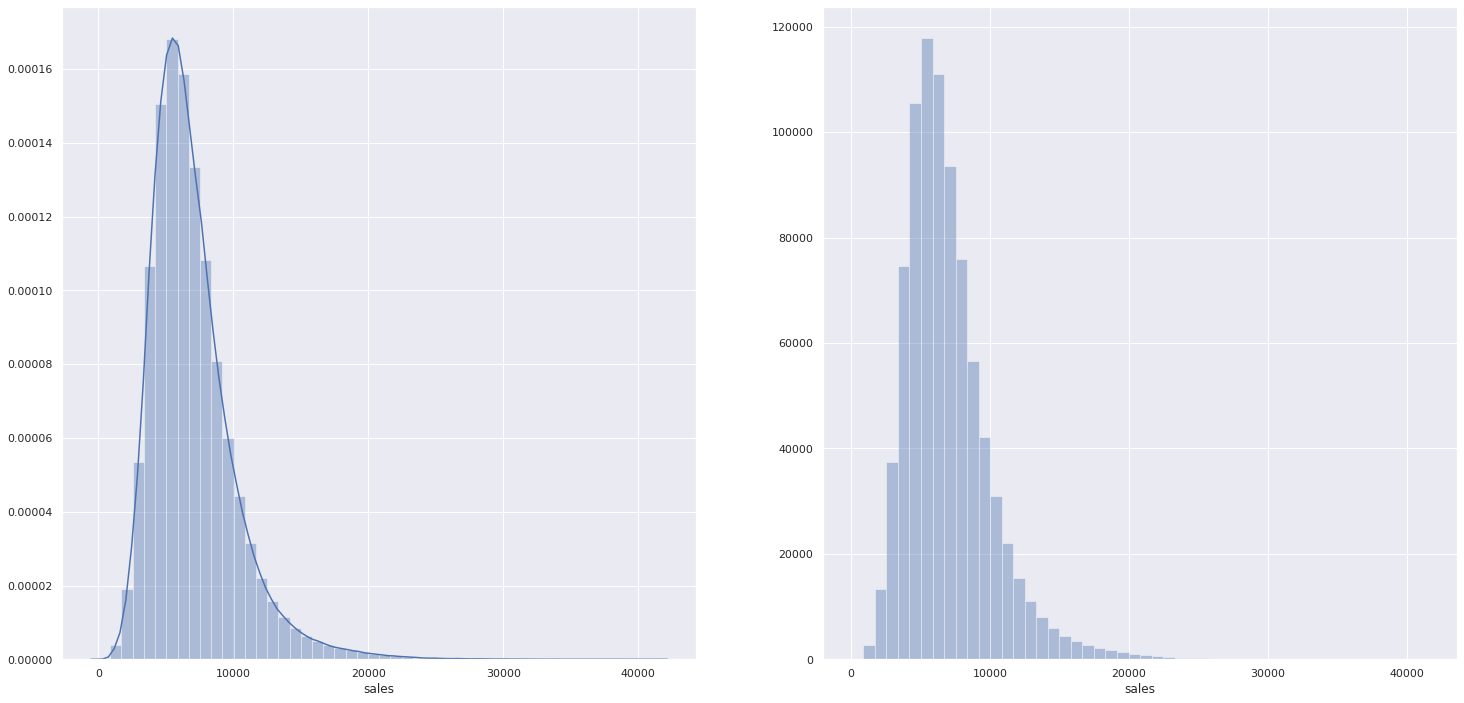

In [28]:
# ditribuição da variável resposta 'sales'
plt.subplot(1, 2, 1)
sns.distplot(df4['sales'])

# histograma da variável resposta 'sales'
plt.subplot(1, 2, 2)
sns.distplot(df4['sales'], kde=False)

### <i><font color="a9a9a9" size=4>4.1.2 Numerical Variable</font></i>

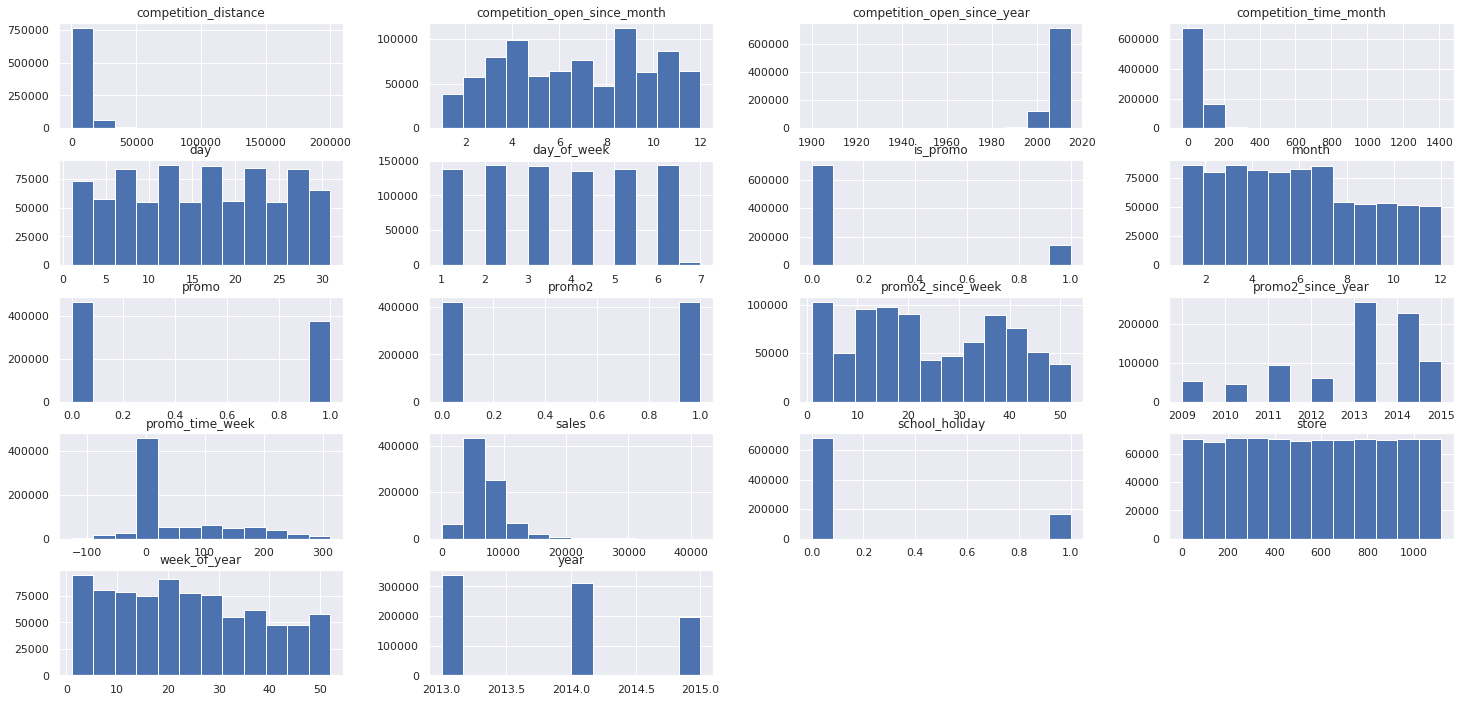

In [29]:
# histogramas de todas as variáveis numéricas do dataset
num_attributes = df4.select_dtypes(include=['int64','float64'])
num_attributes.hist(bins=12);

In [30]:
# variaveis com pouca variabilidade possuem pouca relevância para o aprendizado do modelo: 'day_of_week'
# o contrário vale para a variável 'promo2_since_week' que possui alta variabilidade

# 'competition_distance': os competidores estão a uma distância muito pequena das lojas
# 'competition_open_since_month': a maioria dos competidores abriram há 9 ou 4 meses

### <i><font color="a9a9a9" size=4>4.1.3 Categorical Variable</font></i>

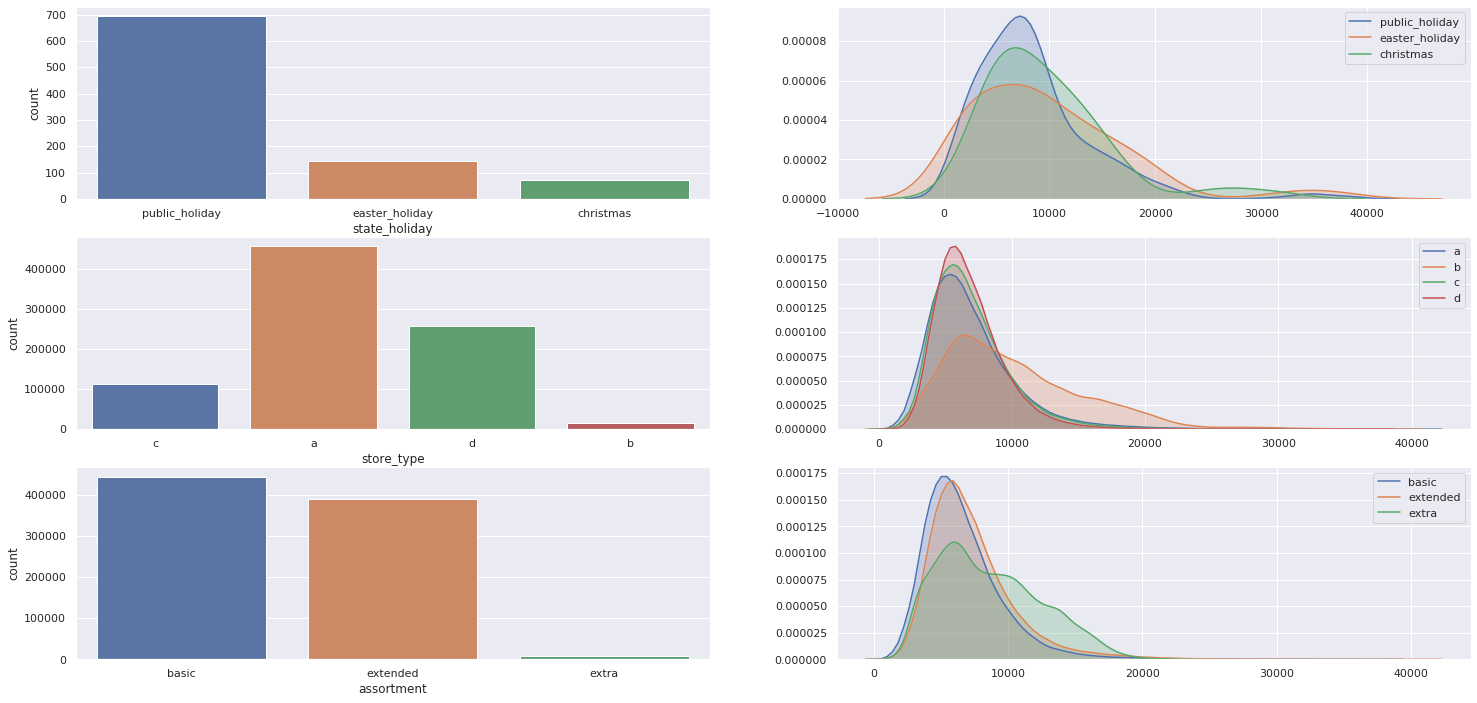

In [31]:
# state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot(3, 2, 2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], 
            label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], 
            label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], 
            label='christmas', shade=True )

# store_type
plt.subplot(3, 2, 3)
sns.countplot( df4['store_type'] )

plt.subplot(3, 2, 4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], 
            label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], 
            label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], 
            label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], 
            label='d', shade=True )

# assortment
plt.subplot(3, 2, 5)
sns.countplot( df4['assortment'] )

plt.subplot(3, 2, 6)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], 
            label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], 
            label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], 
            label='extra', shade=True )

## <i><font color="#708090" size=5 >4.2. Análise Bivariada</font></i>

### <i><font color="#a9a9a9" size=4>4.2.1 Validação das Hipóteses</font></i>

#### **H1.** Lojas com maior sortimento deveriam vender mais.

**FALSE:** Lojas com **MAIOR SORTIMENTO** (assortment == 'extra') vendem **MENOS**

    **INSIGHTS: YES** >> Resultado contraintuitivo, não esperado!

    **RELEVANT: YES** >> Dois comportamentos distintos com uma única variável 

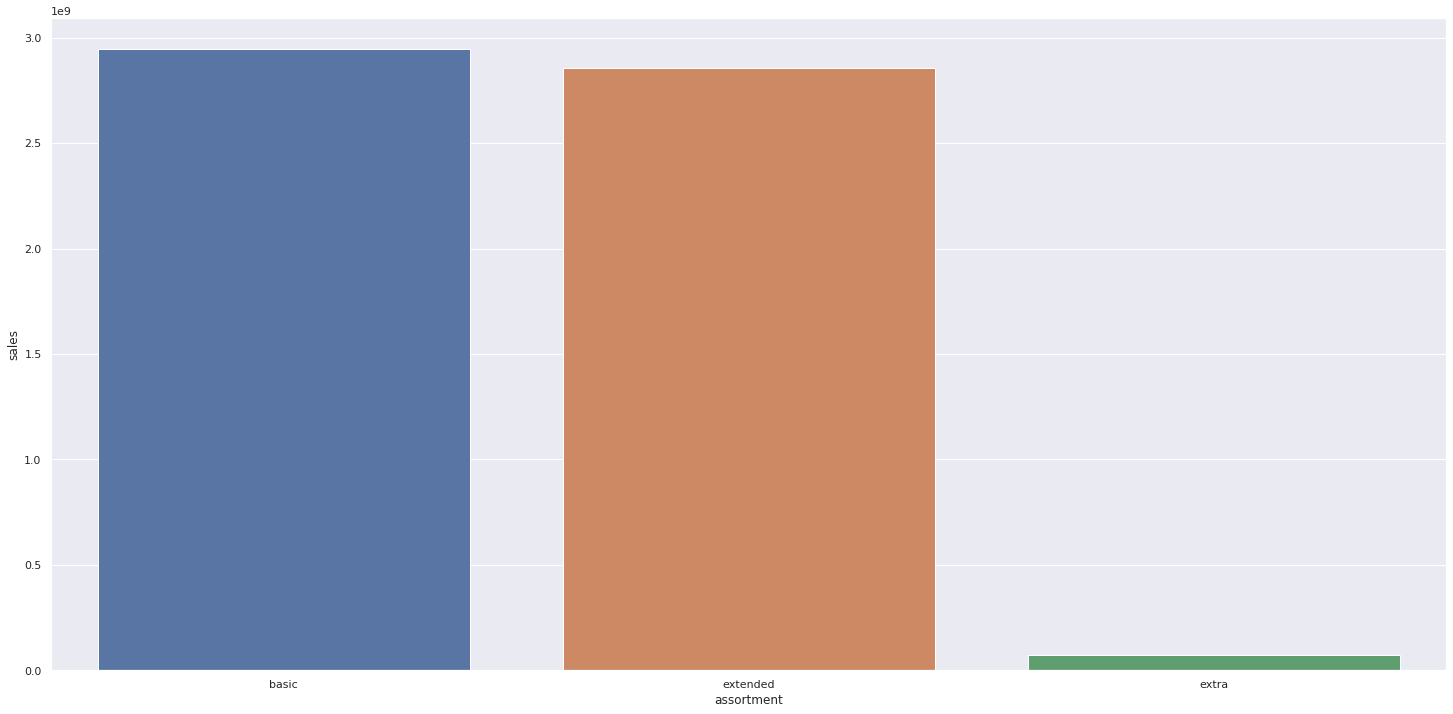

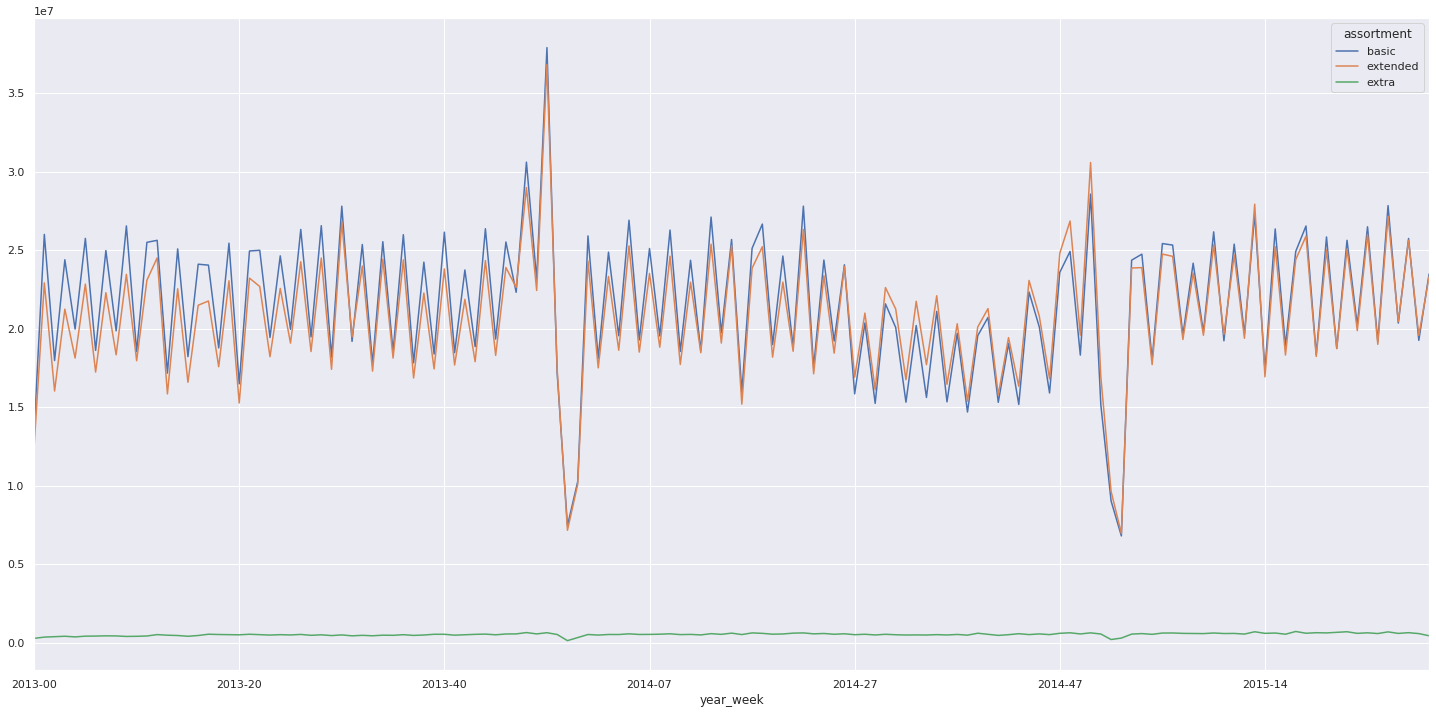

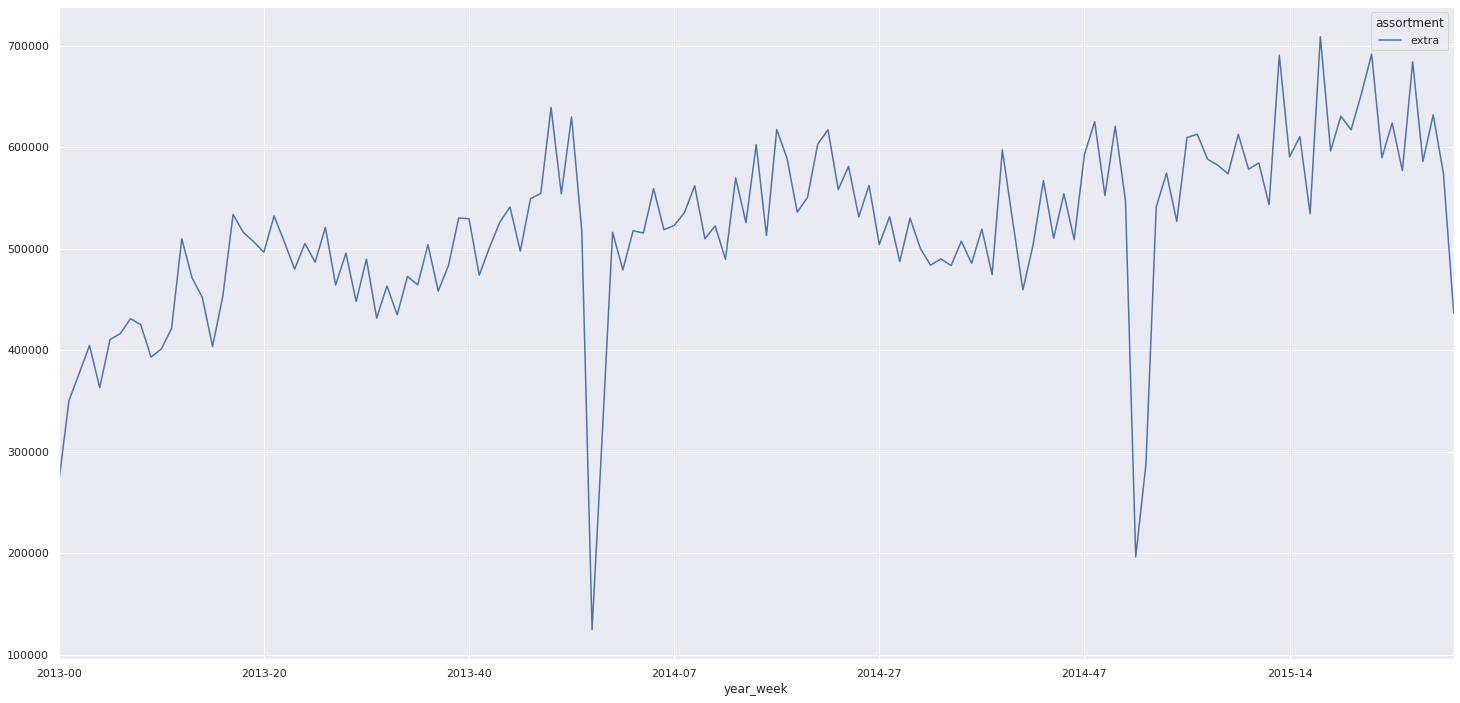

In [32]:
# Montante de vendas por tipo de assortment
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

# Montante de vendas ao longo das semanas dos anos por tipo de assortment
aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales').plot();

# Montante de vendas ao longo das semanas dos anos por tipo de assortment=='extra'
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales').plot();

#### **H2.** Lojas com competidores mais próximos deveriam vender menos.

**FALSE:** Lojas com **COMPETIDORES MAIS PRÓXIMOS** vendem **MAIS**

    **INSIGHTS: YES** >> Resultado contraintuitivo, não esperado!

    **RELEVANT: MAYBE** >> Correlação de Pearson fraca

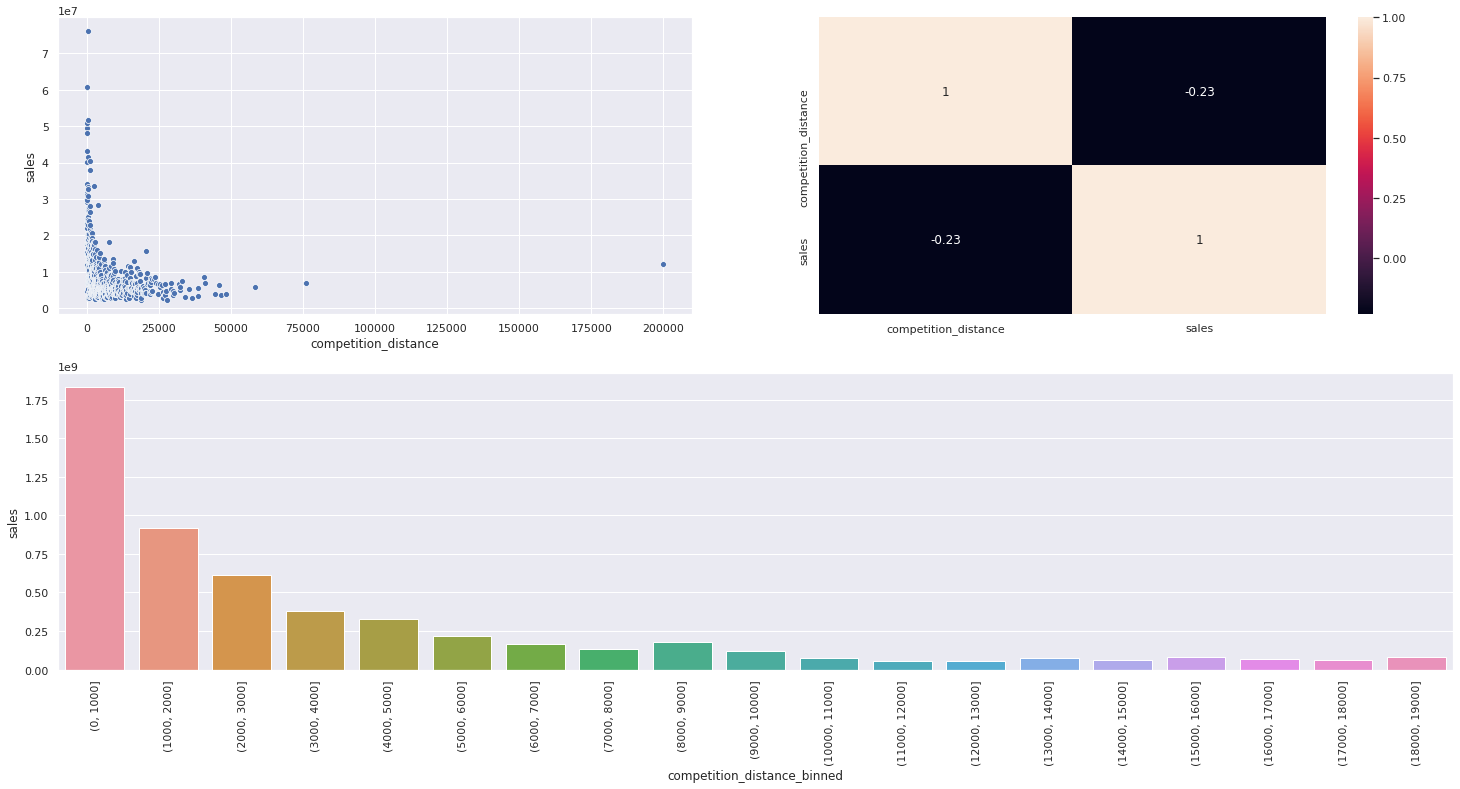

In [33]:
# Montante de vendas por distância dos competidores
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
plt.subplot(2,2,1)
sns.scatterplot( x='competition_distance', y='sales', data=aux1 );

# Correlação entre 'competition_distance' e 'sales'
plt.subplot(2,2,2)
sns.heatmap( aux1.corr( method='pearson'), annot=True);
# bottom, top = x.get_ylim()
# x.set_ylim( bottom+0.5, top-0.5 );

# Agrupamento das distâncias dos competidores de 1000 em 1000
bins = list( np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins )

# Montante de vendas por grupos de distâncias
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
plt.subplot(2,2,(3,4))
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );

#### **H3.** Lojas com competidores há mais tempo deveriam vender mais.

**FALSE:** Quanto **MAIS RECENTE** é a **COMPETIÇÃO**, **MAIS** as lojas vendem

    **INSIGHTS: YES** >> Resultado contraintuitivo, não esperado!

    **RELEVANT: MAYBE** >> Correlação de Pearson fraca

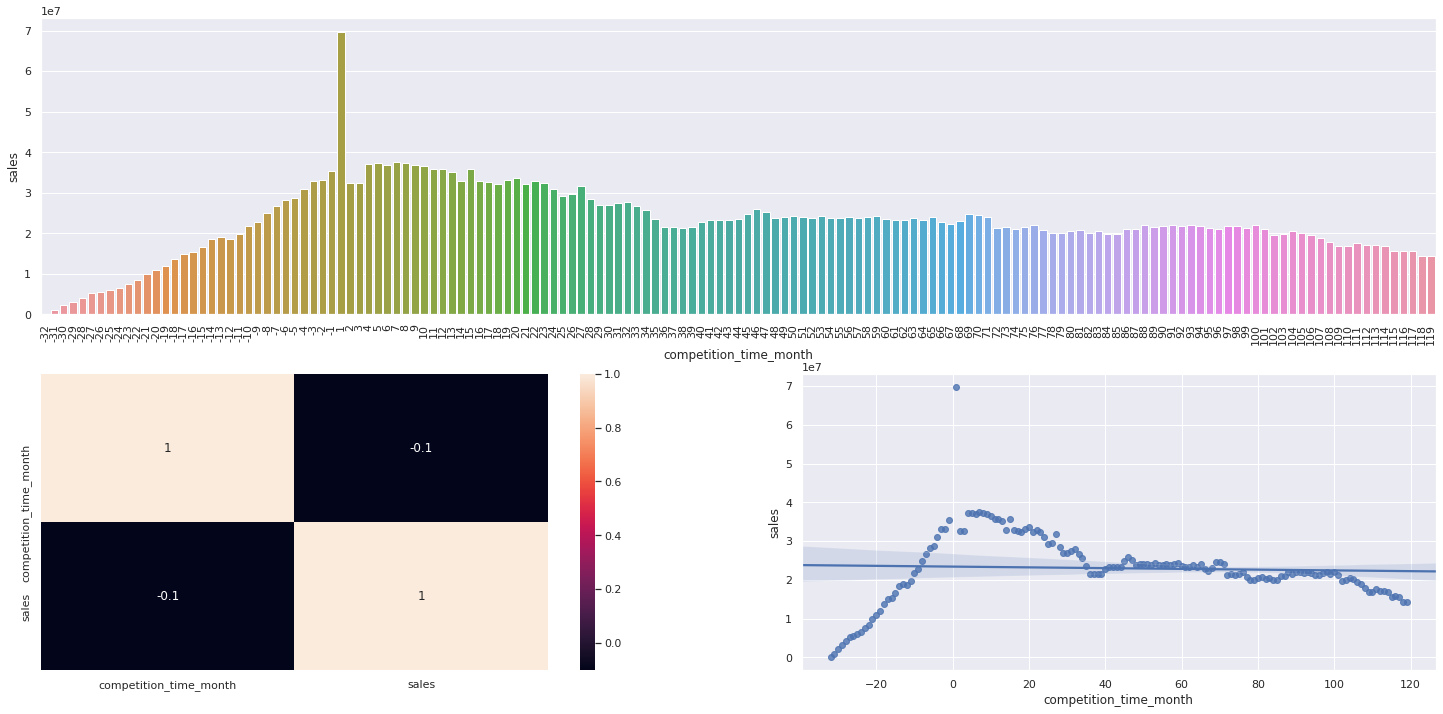

In [34]:
# montante de vendas pelo tempo (em meses) que os competidores abriram, antes ou depois da venda
# valores positivos indicam que a venda foi feita depois da abertura do competidor
# valores negativos indicam que o competidor abriu depois do registro daquela venda
plt.subplot(2,2,(1,2))
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

# Correlação entre 'competition_time_month' e 'sales'
plt.subplot(2,2,3)
sns.heatmap( aux1.corr( method='pearson'), annot=True);

# Tendência
plt.subplot(2,2,4)
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

#### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**FALSE:** Quanto **MAIS RECENTE** é a **PROMOÇÃO**, **MAIS** as lojas vendem. Após um certo período as vendas começam a cair.

    **INSIGHTS: YES** >> Resultado contraintuitivo, não esperado!

    **RELEVANT: MAYBE** >> Correlação de Pearson fraca

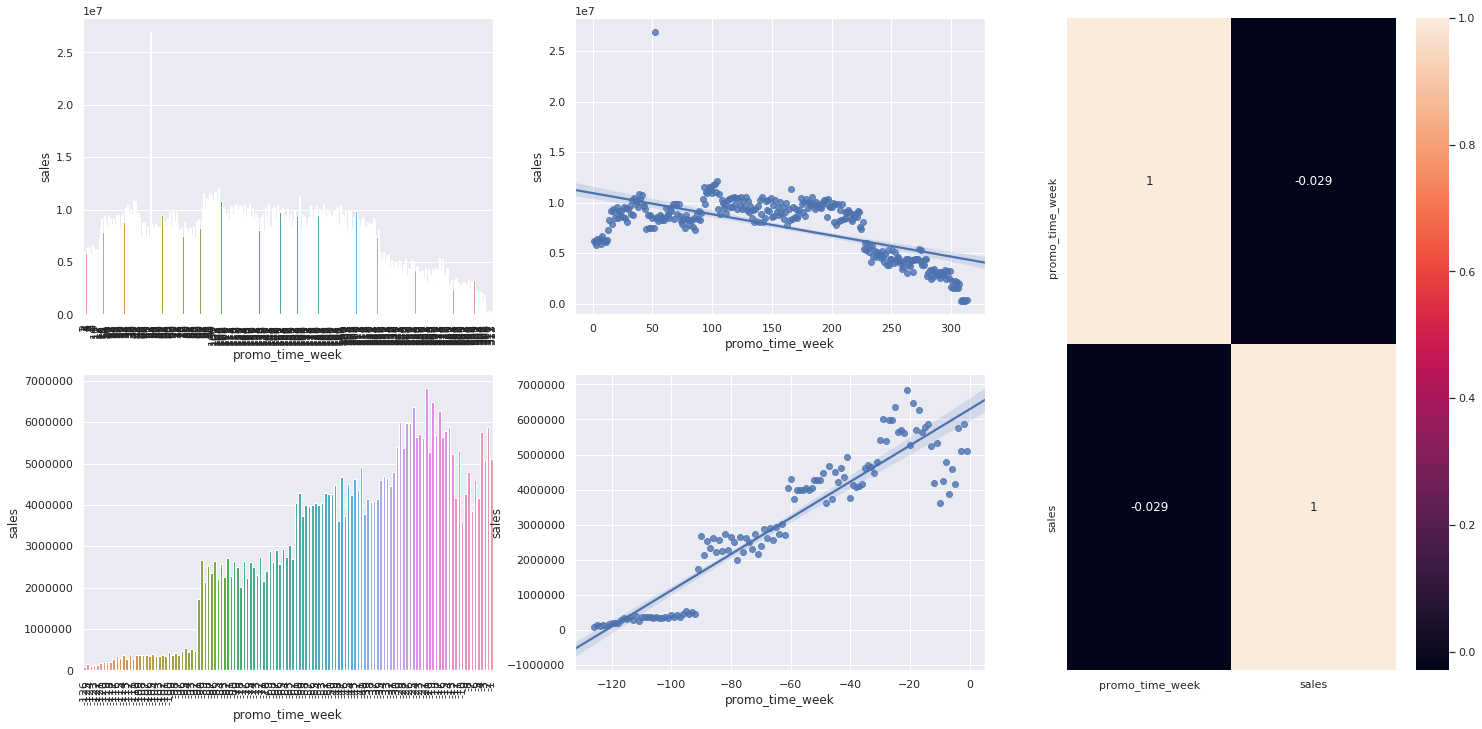

In [35]:
# montante de vendas pelo tempo (em semanas) em que a promoção extendida começou
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

# promoção extendida
plt.subplot(2,3,1)
aux2 = aux1[aux1['promo_time_week'] > 0] 
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );
# Tendência
plt.subplot(2,3,2)
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

# promoção regular
plt.subplot(2,3,4)
aux3 = aux1[aux1['promo_time_week'] < 0] 
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );
# Tendência
plt.subplot(2,3,5)
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

# Correlação entre 'promo_time_week' e 'sales'
plt.subplot(2,3,(3,6))
sns.heatmap( aux1.corr( method='pearson'), annot=True);

#### <s>**H5.** Lojas com mais dias de promoções deveriam vender mais.</s>

**FALSE/TRUE:** Hipótese a ser validada no pŕoximo ciclo CRISP.

#### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.

**FALSE:** Lojas com **MAIS PROMOÇÕES CONSECUTIVAS** vendem **MENOS**.

    **INSIGHTS: YES** >> Resultado contraintuitivo, não esperado!

    **RELEVANT: MAYBE** >> Comportamento ligeiramente variável num dado período

In [36]:
# montante de vendas no período em que a loja esteve ou não em promoção regular e extentida
df4[['promo', 'promo2','sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


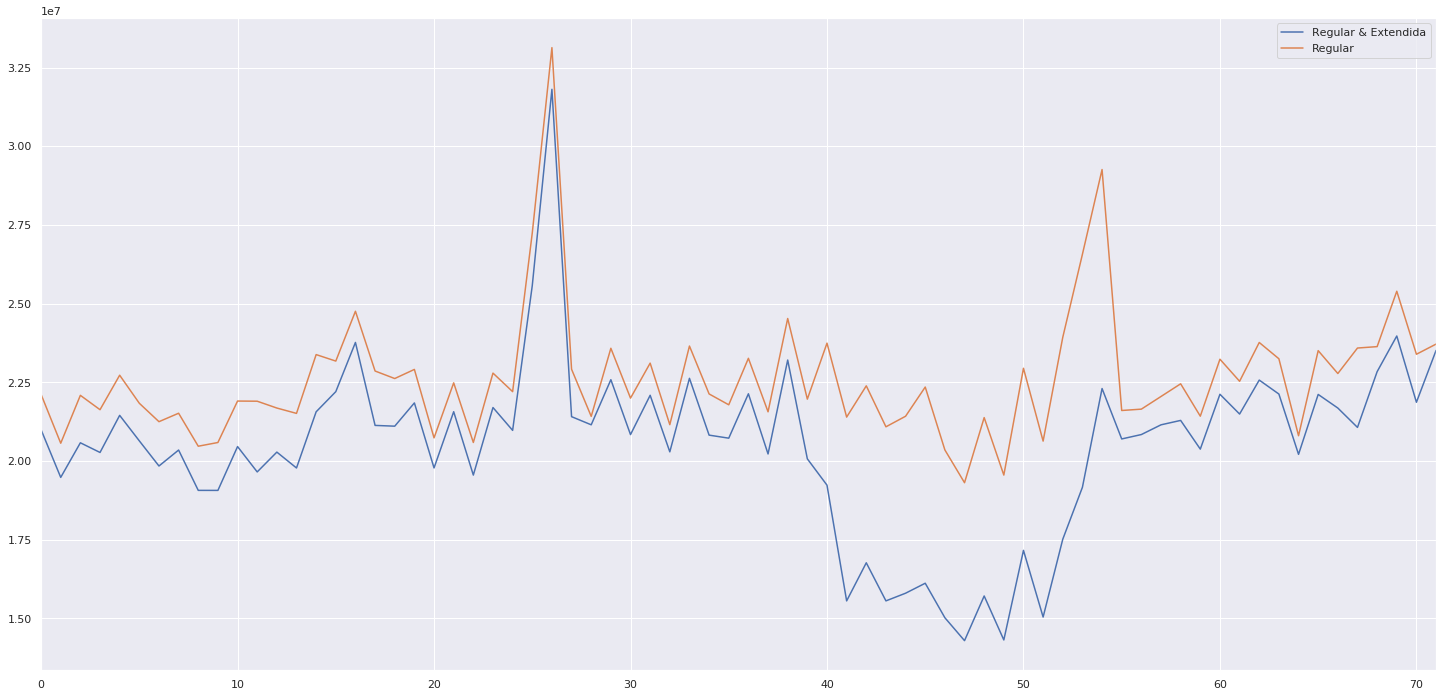

In [37]:
# montante de vendas quando as lojas estiveram em ambos os períodos de promoção
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()

ax = aux1.plot();

# montante de vendas quando as lojas estiveram apenas no período de promoção regular
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax=ax );

ax.legend( labels=['Regular & Extendida', 'Regular']);

#### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**FALSE:** Lojas abertas **NO FERIADO DE NATAL** vendem **MENOS**.

    **INSIGHTS: NO** >> Resultado monitorado e provavelmente esperado!

    **RELEVANT: YES** >> Comportamento crescente ao longo dos anos

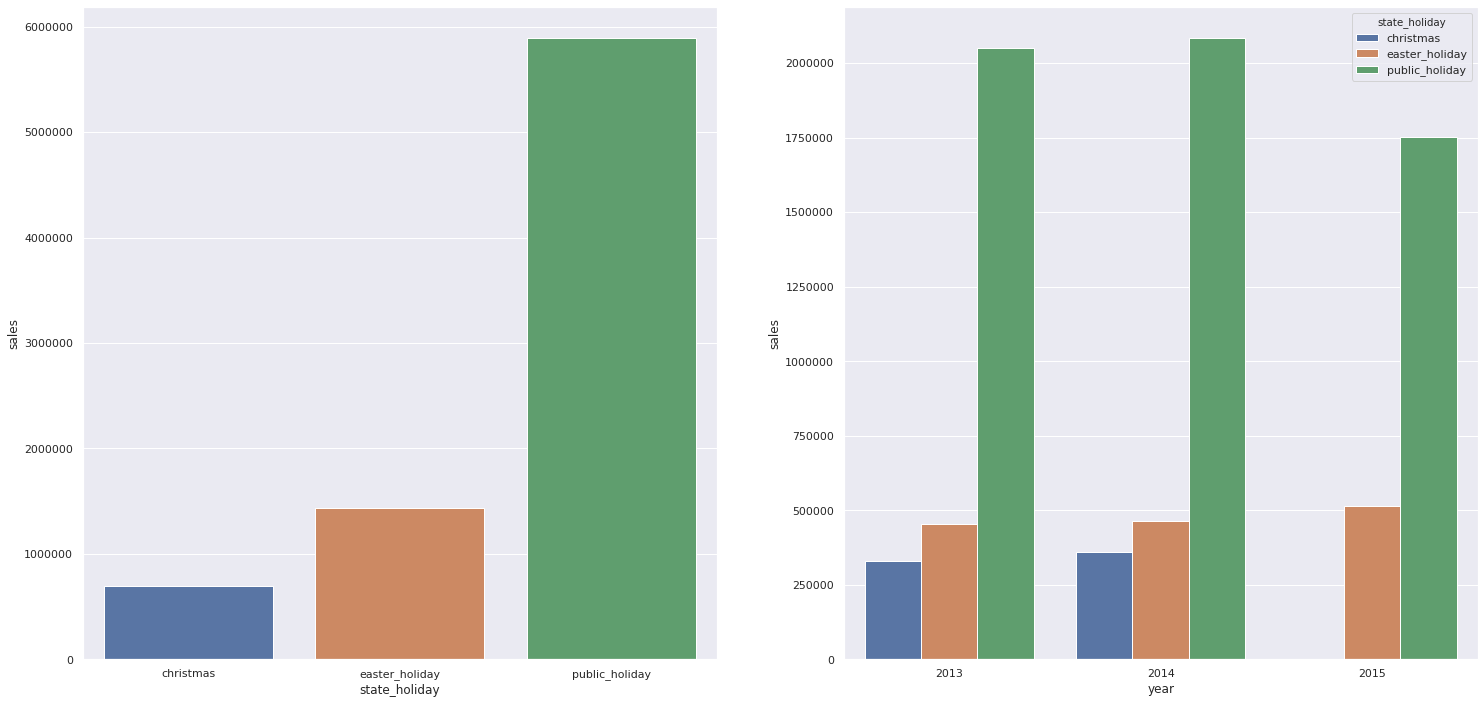

In [38]:
# filtragem dos dados excluindo 'regular_day'
aux = df4[df4['state_holiday'] != 'regular_day']

# montante de vendas de acordo com os feriados
plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1);

# comparativo do montante de vendas ano a ano para cada feriado
plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2);

#### **H8.** Lojas deveriam vender mais ao longo dos anos.

**FALSE:** Lojas vendem **MENOS** ao longo dos **ANOS**.

    **INSIGHTS: NO** >> Resultado monitorado e provavelmente esperado!

    **RELEVANT: YES** >> Comportamento decrescente ao longo dos anos. Correlação Pearson Forte!

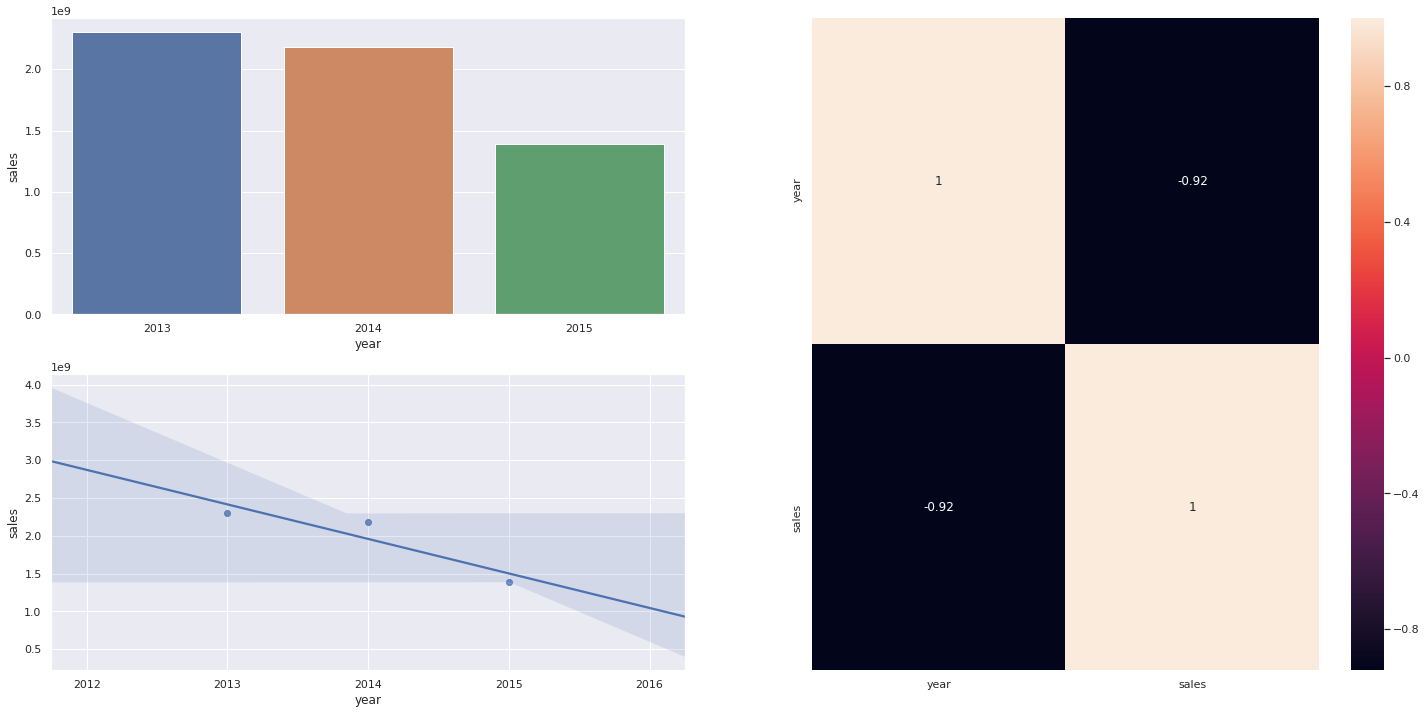

In [39]:
# montante de vendas ao longo dos anos
plt.subplot(2,2,1)
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot( x='year', y='sales', data=aux1);

# Tendência
plt.subplot(2,2,3)
sns.regplot( x='year', y='sales', data=aux1);

# Correlação entre 'year' e 'sales'
plt.subplot(2,2,(2,4))
sns.heatmap( aux1.corr( method='pearson'), annot=True );

#### **H9.** Lojas deveriam vender mais no segundo semestre do ano.

**FALSE:** Lojas vendem **MENOS** durante o **SEGUNDO SEMESTRE DO ANO**.

    **INSIGHTS: NO** >> Resultado provavelmente conhecido pelo negócio.

    **RELEVANT: YES** >> Comportamento decrescente ao longo dos meses. Correlação Pearson Forte!

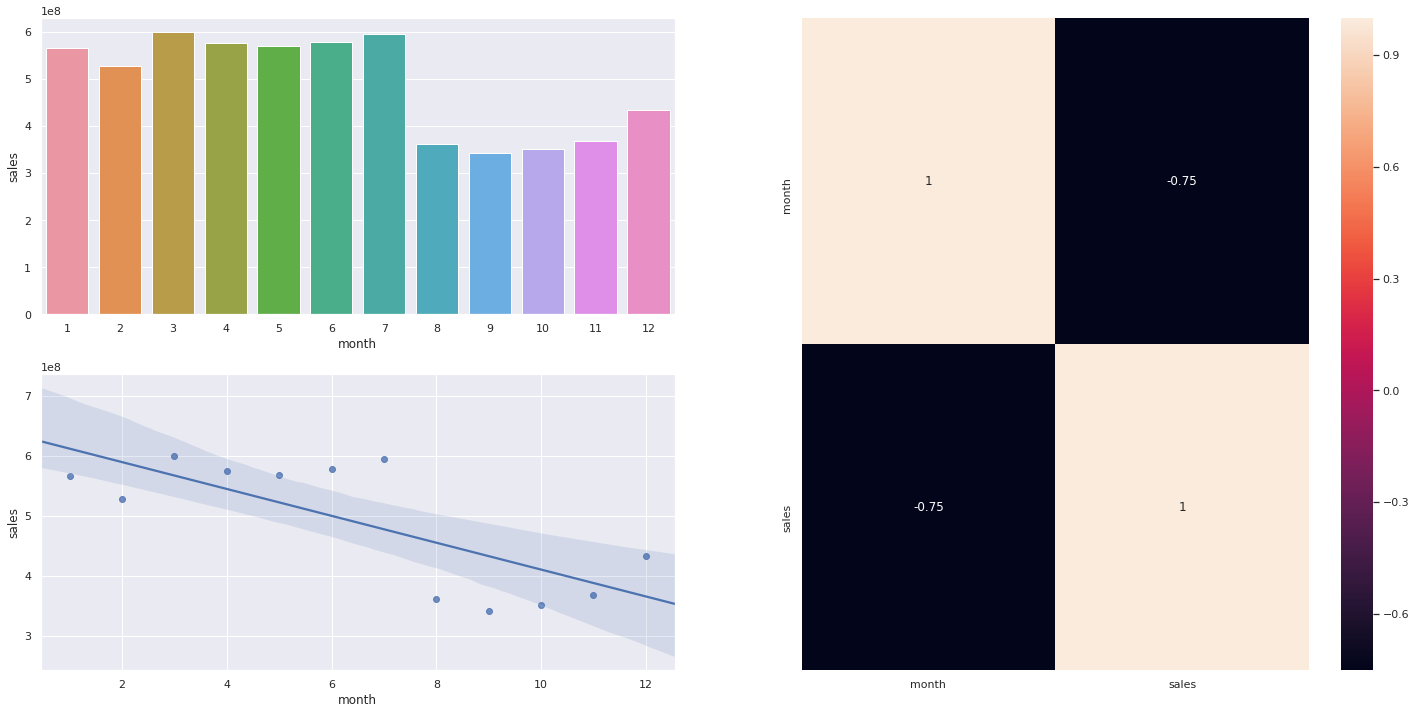

In [40]:
# montante de vendas ao longo dos meses do ano
plt.subplot(2,2,1)
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
sns.barplot( x='month', y='sales', data=aux1);

# Tendência
plt.subplot(2,2,3)
sns.regplot( x='month', y='sales', data=aux1);

# Correlação entre 'month' e 'sales'
plt.subplot(2,2,(2,4))
sns.heatmap( aux1.corr( method='pearson'), annot=True );

#### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mes.

**TRUE:** Lojas vendem **MAIS** depois do **DIA 10 de cada mês**.

    **INSIGHTS: NO** >> Resultado monitorado e provavelmente esperado!

    **RELEVANT: YES** >> Comportamento decrescente ao longo do mês. Correlação Pearson Média!

In [41]:
# coluna auxiliar para contabilizar as vendas antes e após o dia 10 de cada mes
aux1['before_after'] = df4['day'].apply(lambda x: 'before_10_day' if x <= 10 
                                         else 'after_10_day' )

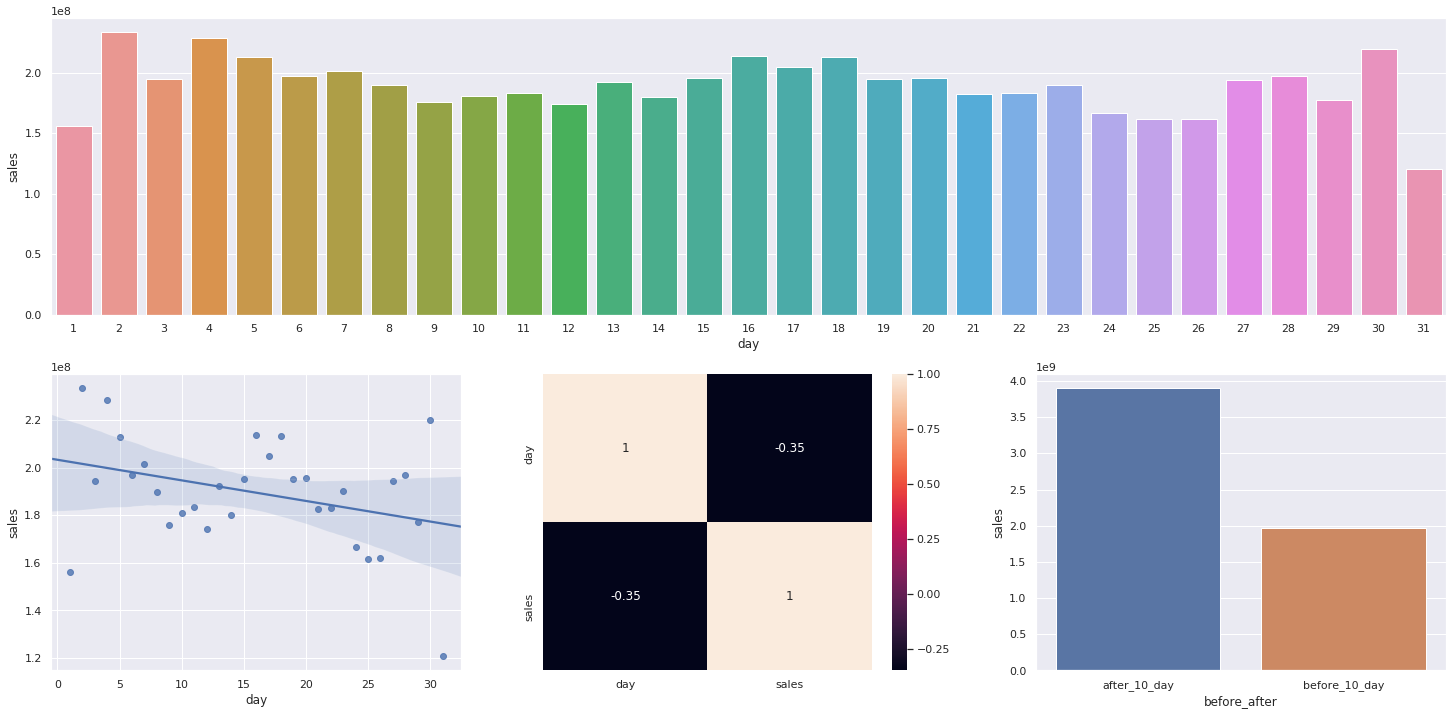

In [42]:
# montante de vendas ao longo dos dias do ano
plt.subplot(2,3,(1,3))
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
sns.barplot( x='day', y='sales', data=aux1);

# Tendência
plt.subplot(2,3,4)
sns.regplot( x='day', y='sales', data=aux1);

# Correlação entre 'day' e 'sales'
plt.subplot(2,3,5)
sns.heatmap( aux1.corr( method='pearson'), annot=True );

# Montante de vendas antes e após o dia 10 de cada mes
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_day' if x <= 10 
                                         else 'after_10_day' )
plt.subplot(2,3,6)
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot( x='before_after', y='sales', data=aux2);

#### **H11.** Lojas deveriam vender menos aos finais de semana.

**TRUE:** Lojas vendem **MENOS** durante **OS FINAIS DE SEMANA**.

    **INSIGHTS: NO** >> Resultado monitorado e provavelmente esperado!

    **RELEVANT: YES** >> Comportamento decrescente ao longo da semana. Correlação Pearson Forte!

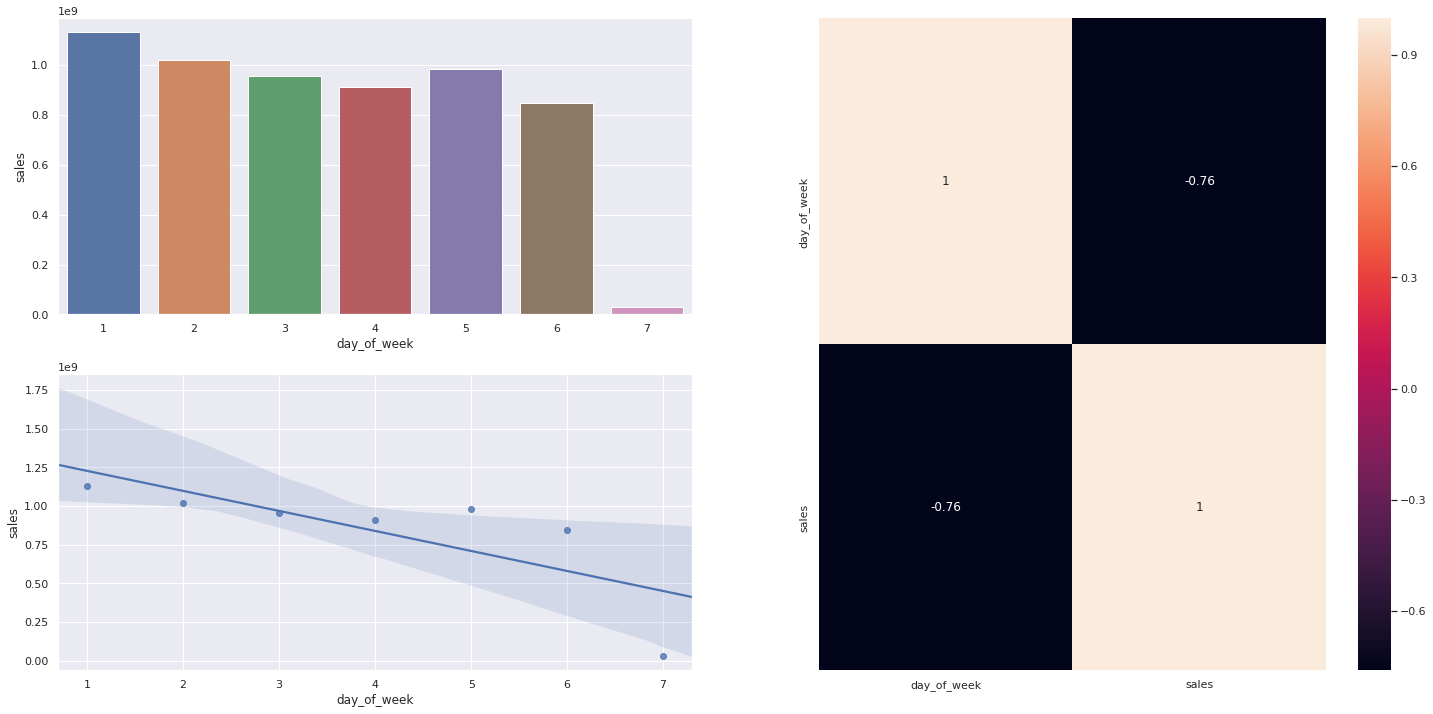

In [43]:
# montante de vendas ao longo dos dias da semana
plt.subplot(2,2,1)
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot( x='day_of_week', y='sales', data=aux1);

# Tendência
plt.subplot(2,2,3)
sns.regplot( x='day_of_week', y='sales', data=aux1);

# Correlação entre 'day_of_week' e 'sales'
plt.subplot(2,2,(2,4))
sns.heatmap( aux1.corr( method='pearson'), annot=True );

#### **H12.** Lojas deveriam vender menos durante os feriados escolares.

**TRUE:** Lojas vendem **MENOS** durante os **FERIADOS ESCOLARES**, com exceção dos meses de férias (Julho e Agosto).

    **INSIGHTS: NO** >> Resultado monitorado e provavelmente esperado!

    **RELEVANT: YES** >> Comportamento variável ao longo do ano, em especial em 2 meses.

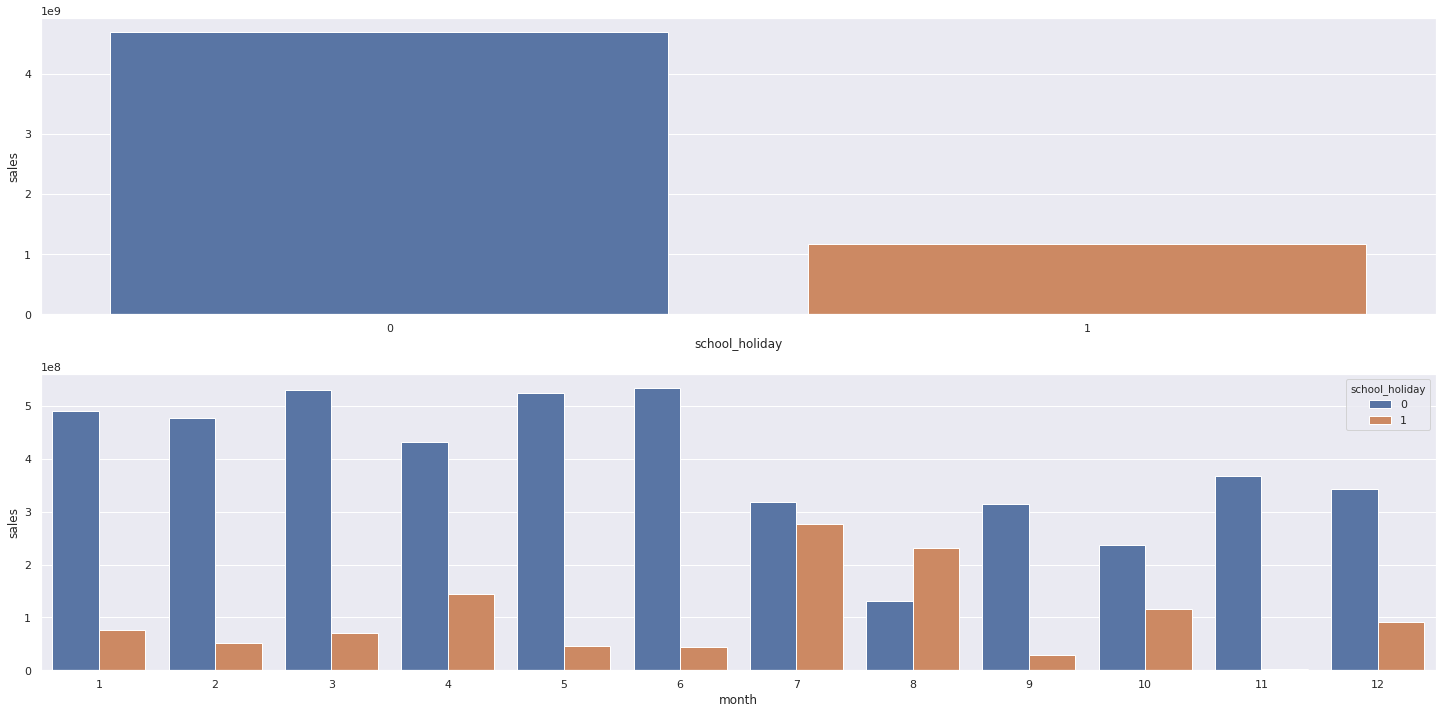

In [44]:
# montante de vendas ao longo dos feriados escolares
plt.subplot(2,1,1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot( x='school_holiday', y='sales', data=aux1 );

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

### <i><font color="#a9a9a9" size=4>4.2.2 Resumo das Hipóteses</font></i>

In [46]:
tab = [['Hipóteses', 'Conclusão', 'Insight', 'Relevância'],
       ['H1', 'FALSE', 'YES', 'YES'],
       ['H2', 'FALSE', 'YES', 'MAYBE'],
       ['H3', 'FALSE', 'YES', 'MAYBE'],
       ['H4', 'FALSE', 'YES', 'MAYBE'],
       ['H5', 'UNK', 'UNK', 'UNK'],
       ['H6', 'FALSE', 'YES', 'MAYBE'],
       ['H7', 'FALSE', 'NO', 'YES'],
       ['H8', 'FALSE', 'NO', 'YES'],
       ['H9', 'FALSE', 'NO', 'YES'],
       ['H10', 'TRUE', 'NO', 'YES'],
       ['H11', 'TRUE', 'NO', 'YES'],
       ['H12', 'TRUE', 'NO', 'YES']]
print( tabulate( tab, headers='firstrow'))

Hipóteses    Conclusão    Insight    Relevância
-----------  -----------  ---------  ------------
H1           FALSE        YES        YES
H2           FALSE        YES        MAYBE
H3           FALSE        YES        MAYBE
H4           FALSE        YES        MAYBE
H5           UNK          UNK        UNK
H6           FALSE        YES        MAYBE
H7           FALSE        NO         YES
H8           FALSE        NO         YES
H9           FALSE        NO         YES
H10          TRUE         NO         YES
H11          TRUE         NO         YES
H12          TRUE         NO         YES


## <i><font color="#708090" size=5 >4.3. Análise Multivariada</font></i>

### <i><font color="#a9a9a9" size=4>4.3.1 Numerical Attributes</font></i>

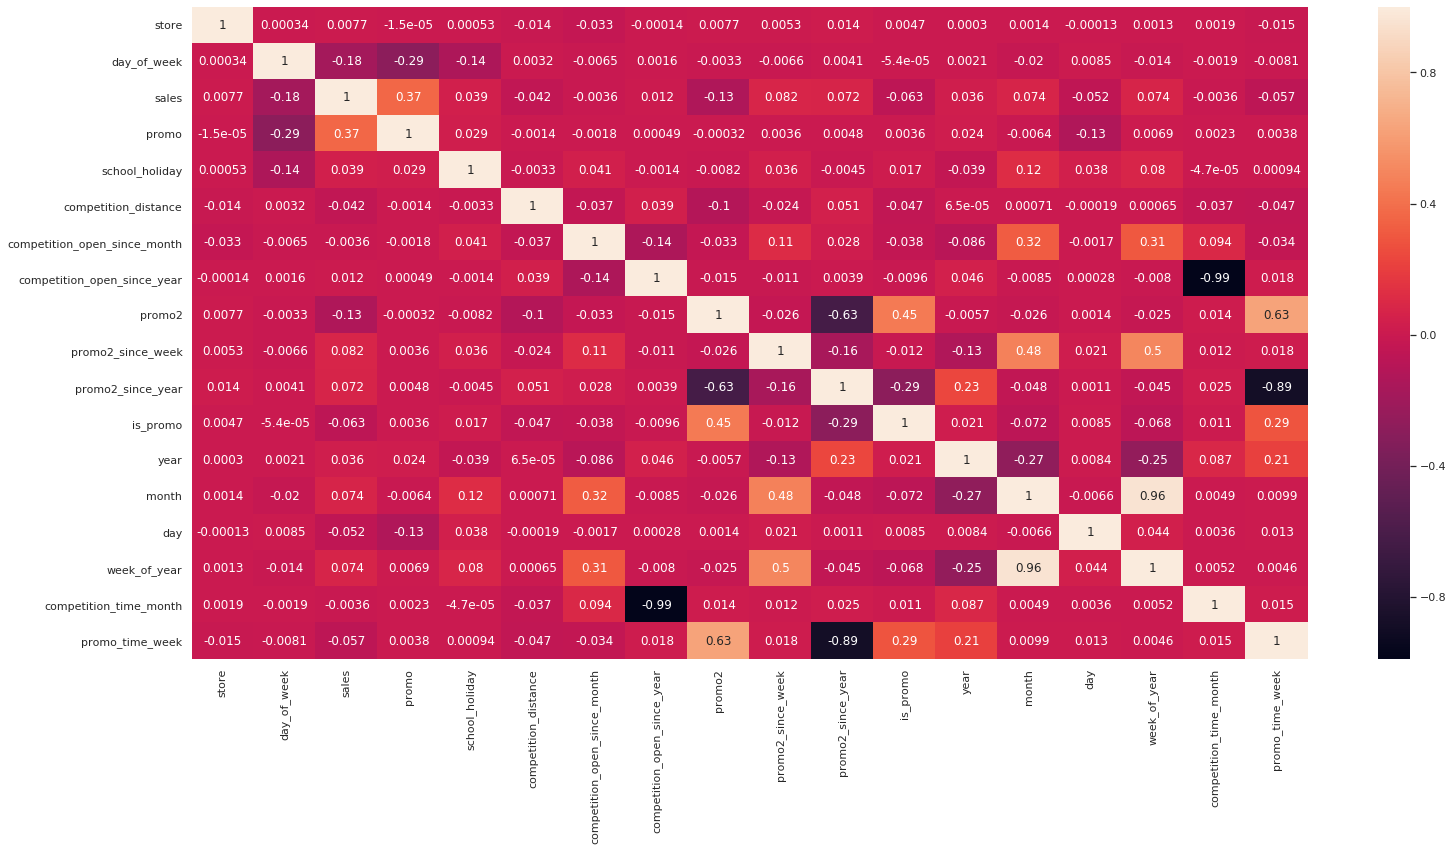

In [47]:
# estudo das correlações entre todos os atributos numéricos (definidos na seção 1.7)
correlation = num_attributes.corr( method='pearson')
sns.heatmap( correlation, annot=True);

### <i><font color="#a9a9a9" size=4>4.3.2 Categorical Attributes</font></i>

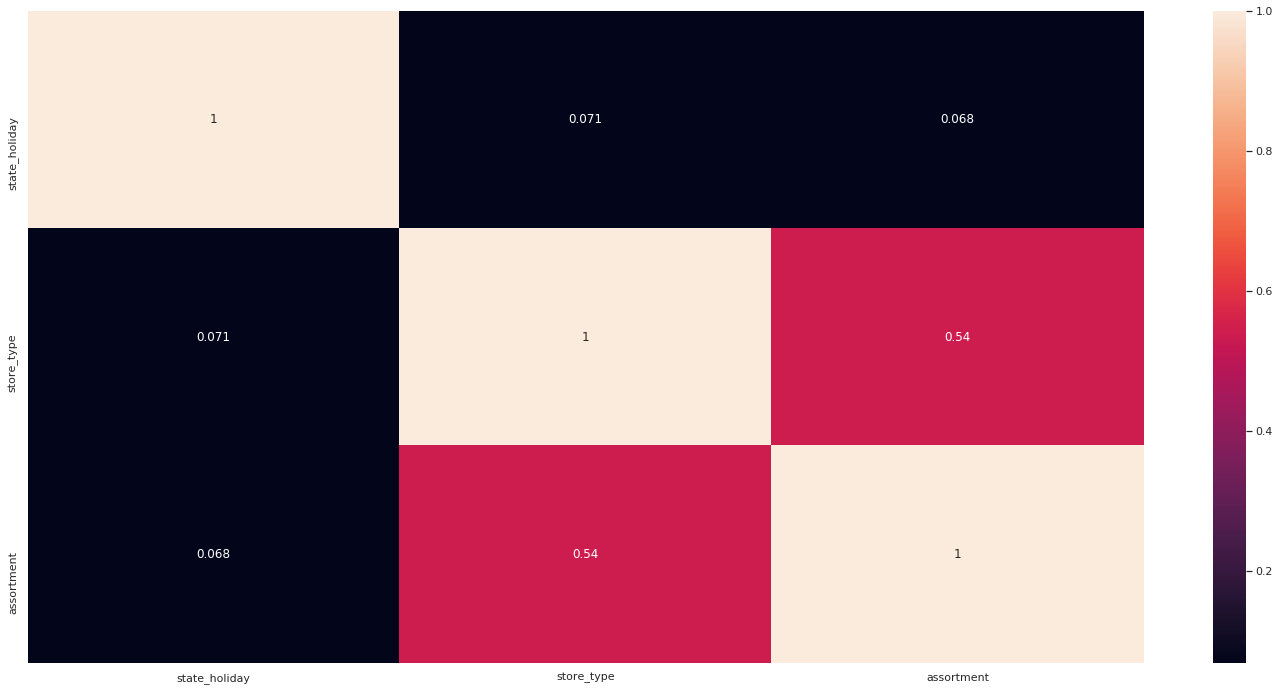

In [48]:
# seleção exclusiva de dados categóricos
a = df4.select_dtypes( include='object' )

# Calculate creamer_v
a1 = cramer_v( a['state_holiday'], a['state_holiday'])
a2 = cramer_v( a['state_holiday'], a['store_type'])
a3 = cramer_v( a['state_holiday'], a['assortment'])

a4 = cramer_v( a['store_type'], a['state_holiday'])
a5 = cramer_v( a['store_type'], a['store_type'])
a6 = cramer_v( a['store_type'], a['assortment'])

a7 = cramer_v( a['assortment'], a['state_holiday'])
a8 = cramer_v( a['assortment'], a['store_type'])
a9 = cramer_v( a['assortment'], a['assortment'])

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                      'store_type': [a4, a5, a6],
                      'assortment': [a7, a8, a9]} )
d = d.set_index( d.columns)
sns.heatmap( d, annot=True );

# 5º PASSO - Preparação dos Dados

In [49]:
# secutiry copy of dataset
df5 = df4.copy()

## <i><font color="#708090" size=5>5.1 Normalização</font></i>

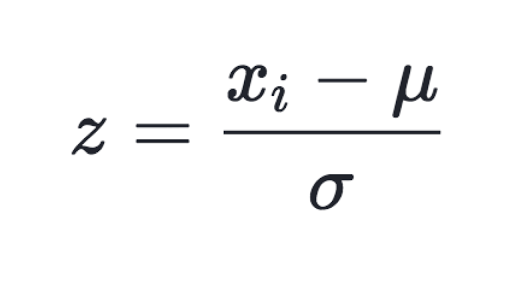

In [50]:
Image('img/Normal.png')

**Z:** valor normalizado
**Xi:** valor original
**μ:** média
**σ:** desvio padrão

Melhor aplicado a variáveis com distribuição normal. Neste caso não há variáveis com tal comportamento no dataset.

## <i><font color="#708090" size=5>5.2 Rescaling</font></i>

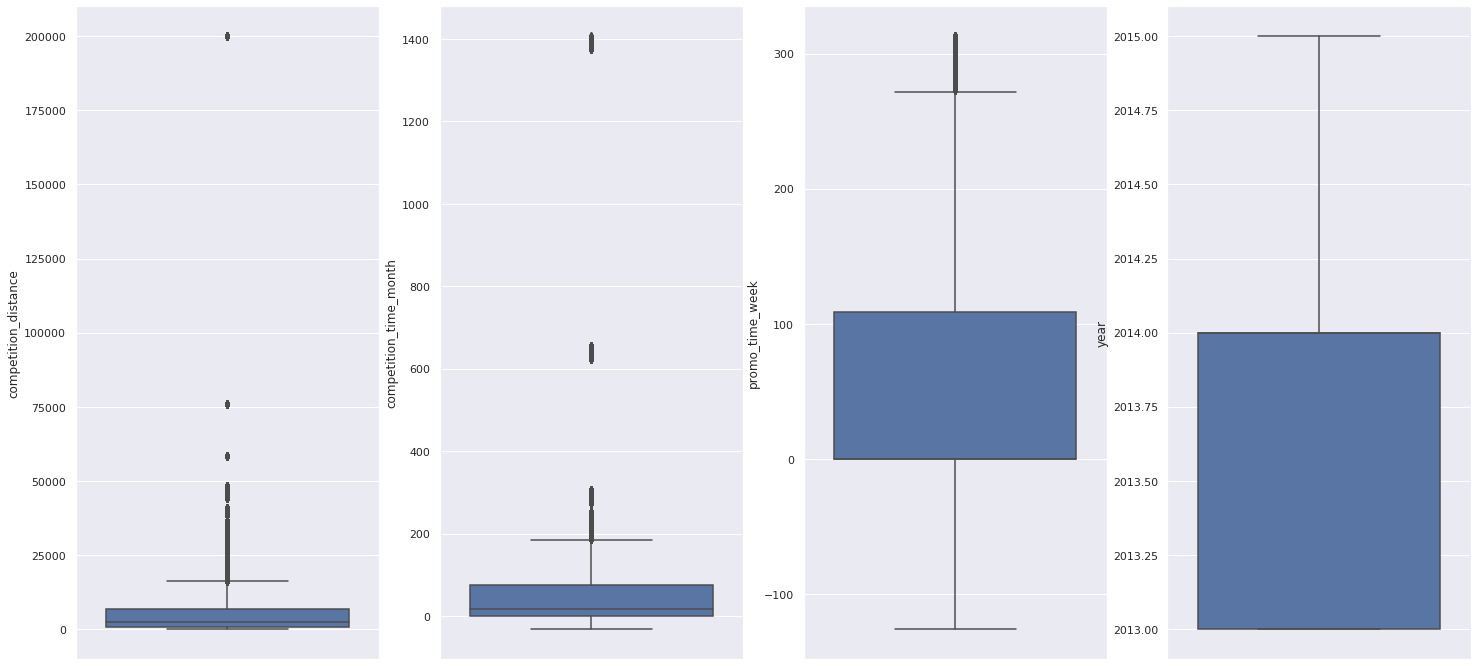

In [51]:
# avaliando a existência de outliers em cada variável
plt.subplot(1,4,1)
sns.boxplot( y=df5['competition_distance']);
plt.subplot(1,4,2)
sns.boxplot( y=df5['competition_time_month']);
plt.subplot(1,4,3)
sns.boxplot( y=df5['promo_time_week']);
plt.subplot(1,4,4)
sns.boxplot( y=df5['year']);

In [52]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance: muitos outliers
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

# competition_time_month: muitos outliers
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

# promo_time_week: poucos outliers
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )

# year: nenhum outlier
df5['year'] = mms.fit_transform( df5[['year']].values )

## <i><font color="#708090" size=5>5.3 Transformação</font></i>

### <i><font color="a9a9a9" size=4>5.3.1 Encoding</font></i>

In [53]:
# state_holiday: estado de feriado e não feriado (ONE HOT ENCODING)
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type: não há relação de ordem entre os níveis (LABEL ENCODING)
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )

# assortment: há uma ordem implícita entre os níveis (ORDINAL ENCODING)
assortment_dict = { 'basic': 1, 'extra': 2, 'extended': 3 }
df5['assortment'] = df5['assortment'].map(assortment_dict)

### <i><font color="a9a9a9" size=4>5.3.2 Response Variable Transformation</font></i>

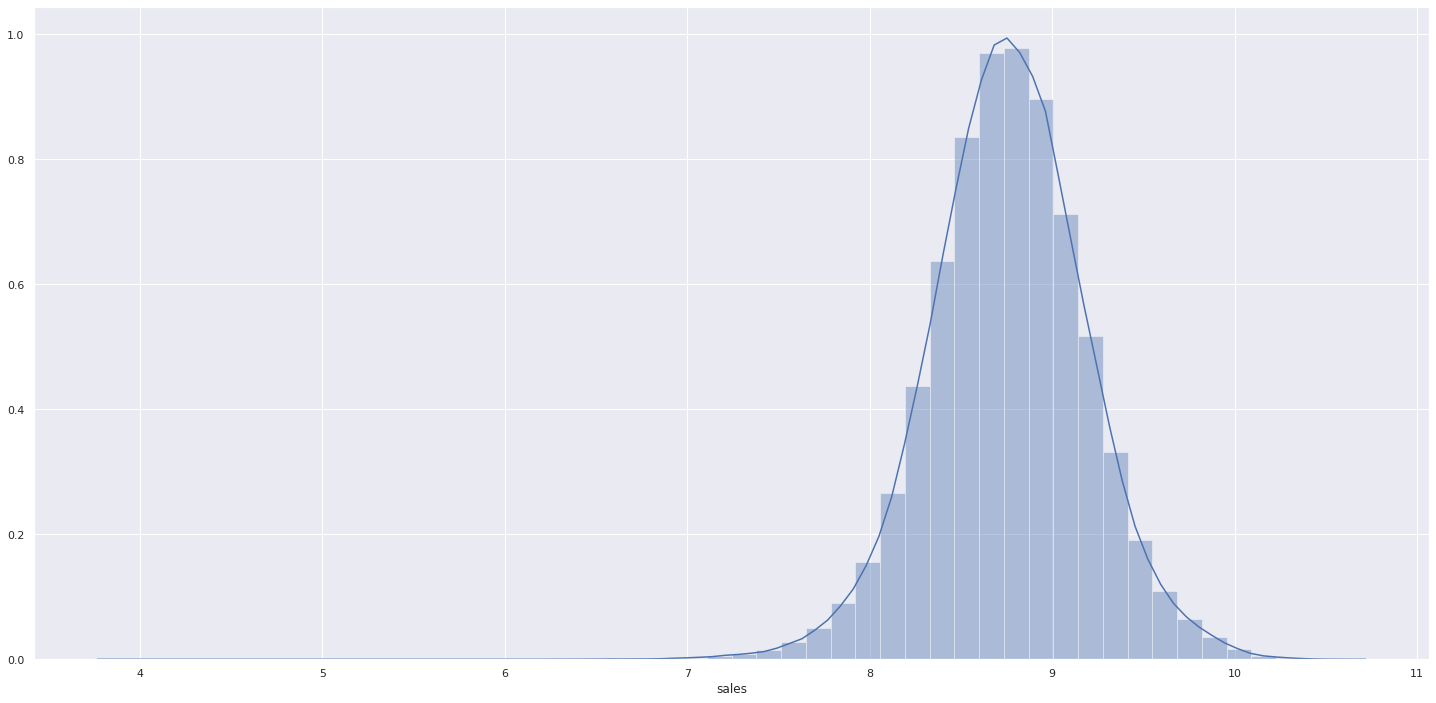

In [54]:
df5['sales'] = np.log1p( df5['sales'] )
sns.distplot( df5['sales'] );

### <i><font color="a9a9a9" size=4>5.3.3 Nature Transformation</font></i>

In [55]:
# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

In [56]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


# 6° PASSO - Feature Selection

In [57]:
# secutiry copy of dataset
df6 = df5.copy()

## <i><font color="#708090" size=5>6.1 Split Dataframe into training and test dataset</font></i>

In [58]:
# deleção de colunas que deram origem a outras colunas nos passos anteriores
cols_drop = ['week_of_year','day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis=1 )

In [61]:
# descobrir a data de 6 semanas antes da última venda de todas as lojas
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days=7*6 )

Timestamp('2015-06-19 00:00:00')

In [65]:
# Dados de Treino (Training Dataset): desde a primeira data até este dia (18/06/2015)
x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']

# Dados de Teste (Test Dataset): desde esta data (19/06/2015) até a última data
x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_test['sales']

print( 'Traning Min Date: {}'.format( x_train['date'].min() ) )
print( 'Traning Max Date: {}\n'.format( x_train['date'].max() ) )

print( 'Test Min Date: {}'.format( x_test['date'].min() ) )
print( 'Test Max Date: {}'.format( x_test['date'].max() ) )

Traning Min Date: 2013-01-01 00:00:00
Traning Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## <i><font color="#708090" size=5>6.2 Boruta as Feature Selector</font></i>

In [72]:
# training and test dataset for Boruta: drop response columns
x_train_n = x_train.drop( ['date', 'sales'], axis=1 ).values
y_train_n = y_train.values.ravel()

# Define RandomForestRegressor
rf = RandomForestRegressor( n_jobs=-1 )

# Define Boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(x_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### <i><font color="a9a9a9" size=4>6.2.1 Best Features from Boruta</font></i>

In [73]:
cols_selected = boruta.support_.tolist()

# best features
x_train_fs = x_train.drop( ['date', 'sales'], axis=1 )
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected Boruta
cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta) )

In [74]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos']

In [75]:
cols_not_selected_boruta

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

## <i><font color="#708090" size=5>6.3 Manual Feature Selection</font></i>

In [76]:
# comparar com a validação de hipóteses da EDA (seção 4.2.2)
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'month_sin'
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin'
    'week_of_year_cos',
    'day_of_week_sin',
    'day_of_week_cos']

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta.extend (feat_to_add)